In this notebook, I'll use the dataset "StackSample: 10% of Stack Overflow Q&A", I'll only use the questions and the tags. 
I will implement a tag suggestion system. I'll both try machine learning models and deep learning models like Word2Vec. I'll then compare the performance of both approaches. 

This notebook will be divided in 2 parts:
* PART 1 : Cleaning data and EDA
* PART 2 : Classical classifiers implemented (SGC classifier, MultiNomial Naive Bayes Classifier, Random Forest Classfier, ...


**PART 1: Cleaning Data and Exploratory Data Analysis**

**1.1 Setting up the dataset for later training**

Importing useful libraries at first

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import warnings

import pickle
import time
import os

import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn.cluster import KMeans


import logging

from scipy.sparse import hstack

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline

In [2]:
# Setting a random seed in order to keep the same random results each time I run the notebook
np.random.seed(seed=11)

In [3]:
# Importing the database 

df = pd.read_csv("Downloads/Data/Questions.csv", encoding="ISO-8859-1")

In [4]:
df.head(5)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [5]:
tags = pd.read_csv("Downloads/Data/Tags.csv", encoding="ISO-8859-1", dtype={'Tag': str})

In [6]:
tags.head(5)

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Id            1264216 non-null  int64  
 1   OwnerUserId   1249762 non-null  float64
 2   CreationDate  1264216 non-null  object 
 3   ClosedDate    55959 non-null    object 
 4   Score         1264216 non-null  int64  
 5   Title         1264216 non-null  object 
 6   Body          1264216 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


In [8]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


First, what I want to do is to merge both dataframes. In order to do that, I'll have to group tags by the id of the post since a post can have multiple tags. I'll just use the groupeby function and then merge the dataframes on the id. 

In [9]:
tags['Tag'] = tags['Tag'].astype(str)

In [10]:
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))

In [11]:
grouped_tags.head(5)

Id
80                            flex actionscript-3 air
90       svn tortoisesvn branch branching-and-merging
120                               sql asp.net sitemap
180    algorithm language-agnostic colors color-space
260           c# .net scripting compiler-construction
Name: Tag, dtype: object

In [12]:
grouped_tags.reset_index()

,Id,Tag
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
...,...,...
1264211,40143210,php .htaccess
1264212,40143300,google-bigquery
1264213,40143340,android android-studio
1264214,40143360,javascript vue.js


In [13]:
grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})

In [14]:
grouped_tags_final.head(5)

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction


In [15]:
df.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)

In [16]:
df = df.merge(grouped_tags_final, on='Id')

In [17]:
df.head(5)

,Id,Score,Title,Body,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


Now, I'll take only quesions witha score greater than 5. I'm doing that for 2 reasons:
* 1- I'll require less computational resources from kaggle.
* 2- The posts will probably be with a better quality and will be better tagged since they have lots of upvotes. 


In [18]:
new_df = df[df['Score']>5]

**1.2 Cleaning Data**

Text(0.5, 1.0, 'Ratio of missing values per columns')

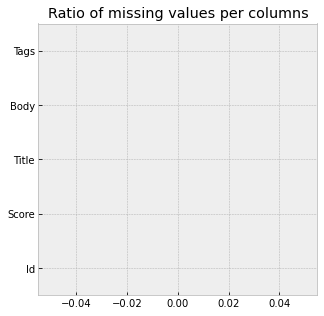

In [19]:
plt.figure(figsize=(5, 5))
new_df.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [20]:
print('Dupplicate entries: {}'.format(new_df.duplicated().sum()))
new_df.drop_duplicates(inplace = True)

Dupplicate entries: 0


This is a very good dataset since there are no missing valeus or dupplicate values. 

In [21]:
new_df.drop(columns=['Id', 'Score'], inplace=True)

Now we only need 3 columns: Body, Title and Tags. 

**1.2.1 Tags**

Let's do some cleaning on the tags' column. Furthermore, I decided to keep the 100 most popular tags because I'll be easier to predict the right tag from 100 words than from 14,000 and because we want to keep macro tags and not be too specific since it's only a recommendation for a post, the user can add more specific tags himself. 

In [22]:
new_df.head(5)

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [23]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: x.split())

In [24]:
all_tags = [item for sublist in new_df['Tags'].values for item in sublist]

In [25]:
len(all_tags)

224129

In [26]:
my_set = set(all_tags)
unique_tags = list(my_set)
len(unique_tags)

14883

In [27]:
flat_list = [item for sublist in new_df['Tags'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)

keywords = nltk.FreqDist(keywords)

frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]

In [28]:
tags_features

['c#',
 'java',
 'javascript',
 'android',
 'python',
 'c++',
 'php',
 'jquery',
 '.net',
 'ios',
 'html',
 'css',
 'c',
 'iphone',
 'objective-c',
 'ruby-on-rails',
 'sql',
 'asp.net',
 'mysql',
 'ruby',
 'r',
 'git',
 'asp.net-mvc',
 'linux',
 'sql-server',
 'node.js',
 'angularjs',
 'django',
 'performance',
 'algorithm',
 'string',
 'xcode',
 'arrays',
 'wpf',
 'eclipse',
 'haskell',
 'windows',
 'scala',
 'multithreading',
 'json',
 'c++11',
 'regex',
 'visual-studio',
 'html5',
 'osx',
 'swift',
 'database',
 'unit-testing',
 'spring',
 'xml',
 'bash',
 'ajax',
 'delphi',
 'cocoa-touch',
 'ruby-on-rails-3',
 'visual-studio-2010',
 'linq',
 'debugging',
 'generics',
 'perl',
 'entity-framework',
 'mongodb',
 'winforms',
 'cocoa',
 'security',
 'postgresql',
 'css3',
 'templates',
 'twitter-bootstrap',
 'shell',
 'list',
 'google-chrome',
 'vim',
 'oop',
 'image',
 'hibernate',
 'gcc',
 'asp.net-mvc-3',
 'facebook',
 'oracle',
 'rest',
 'maven',
 'http',
 'exception',
 'tsql',
 'ma

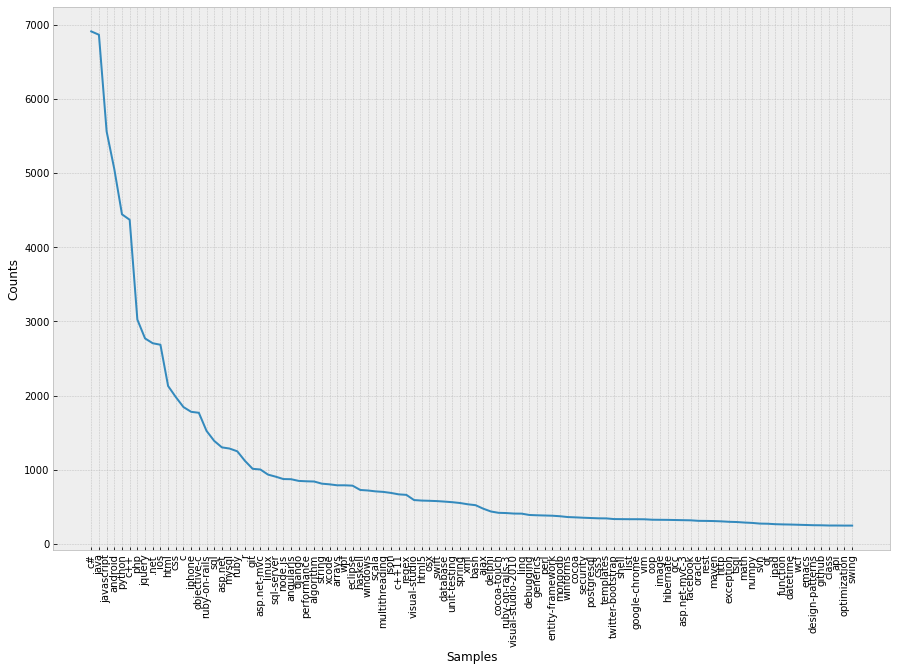

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [29]:
fig, ax = plt.subplots(figsize=(15, 10))
keywords.plot(100, cumulative=False)

In [30]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [31]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: most_common(x))
new_df['Tags'] = new_df['Tags'].apply(lambda x: x if len(x)>0 else None)

In [32]:
new_df.shape

(72950, 3)

In [33]:
new_df.dropna(subset=['Tags'], inplace=True)

In [34]:
new_df.shape

(63167, 3)

We are here loosing 10000 rows but the it's for the greater good. 

**1.2.2 Body**

In the next two columns: Body and Title, I'll use lots of text processing:
* Removing html format 
* Lowering text
* Transforming abbreviations 
* Removing punctuation (but keeping words like c# since it's the most popular tag)
* Lemmatizing words
* Removing stop words

In [35]:
# Converting html to text in the body

new_df['Body'] = new_df['Body'].apply(lambda x: BeautifulSoup(x).get_text()) 

In [36]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [37]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_text(x)) 

In [38]:
token=ToktokTokenizer()

In [39]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [40]:
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [41]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

In [42]:
def clean_punct(text): 
    words=token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
        if w in tags_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))
  
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))




In [43]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_punct(x)) 

In [44]:
new_df['Body'][2]

'has anyone got experience creating sql-based asp.net site-map providers i have got the default xml file websitemap working properly with my menu and sitemappath controls but i will need a way for the users of my site to create and modify pages dynamically i need to tie page viewing permissions into the standard asp.net membership system as well'

In [45]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [52]:
nltk.download_shell()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all


       | 
       | Downloading package abc to
       |     C:\Users\ADMIN\AppData\Roaming\nltk_data...
       |   Package abc is already up-to-date!
       | Downloading package alpino to
       |     C:\Users\ADMIN\AppData\Roaming\nltk_data...
       |   Package alpino is already up-to-date!
       | Downloading package averaged_perceptron_tagger to
       |     C:\Users\ADMIN\AppData\Roaming\nltk_data...
       |   Package averaged_perceptron_tagger is already up-to-date!
       | Downloading package averaged_perceptron_tagger_ru to
       |     C:\Users\ADMIN\AppData\Roaming\nltk_data...
       |   Package averaged_perceptron_tagger_ru is already up-to-
       |       date!
       | Downloading package basque_grammars to
       |     C:\Users\ADMIN\AppData\Roaming\nltk_data...
       |   Package basque_grammars is already up-to-date!
       | Downloading package biocreative_ppi to
       |     C:\Users\ADMIN\AppData\Roaming\nltk_data...
       |   Package biocreative_ppi is already 

       | Downloading package paradigms to
       |     C:\Users\ADMIN\AppData\Roaming\nltk_data...
       |   Unzipping corpora\paradigms.zip.
       | Downloading package pe08 to
       |     C:\Users\ADMIN\AppData\Roaming\nltk_data...
       |   Unzipping corpora\pe08.zip.
       | Downloading package perluniprops to
       |     C:\Users\ADMIN\AppData\Roaming\nltk_data...
       |   Unzipping misc\perluniprops.zip.
       | Downloading package pil to
       |     C:\Users\ADMIN\AppData\Roaming\nltk_data...
       |   Unzipping corpora\pil.zip.
       | Downloading package pl196x to
       |     C:\Users\ADMIN\AppData\Roaming\nltk_data...
       |   Unzipping corpora\pl196x.zip.
       | Downloading package porter_test to
       |     C:\Users\ADMIN\AppData\Roaming\nltk_data...
       |   Unzipping stemmers\porter_test.zip.
       | Downloading package ppattach to
       |     C:\Users\ADMIN\AppData\Roaming\nltk_data...
       |   Unzipping corpora\ppattach.zip.
       | Downloading 


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


In [53]:
lemma=WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [54]:
def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    
    stop_words = set(stopwords.words("english"))
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))

In [55]:
new_df['Body'] = new_df['Body'].apply(lambda x: lemitizeWords(x)) 
new_df['Body'] = new_df['Body'].apply(lambda x: stopWordsRemove(x)) 

**1.2.3 Title**

In [56]:
new_df['Title'] = new_df['Title'].apply(lambda x: str(x))
new_df['Title'] = new_df['Title'].apply(lambda x: clean_text(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: clean_punct(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: lemitizeWords(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: stopWordsRemove(x)) 

**1.3 EDA**

Here I'll just use some LDA to see if shows any paterns in words and the main topics.  

In [57]:
no_topics = 20

In [58]:
text = new_df['Body']

In [59]:
vectorizer_train = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                       max_features=1000)

In [60]:
TF_IDF_matrix = vectorizer_train.fit_transform(text)

In [61]:
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50,random_state=11).fit(TF_IDF_matrix)

In [62]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("--------------------------------------------")
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("--------------------------------------------")
        

no_top_words = 10
display_topics(lda, vectorizer_train.get_feature_names(), no_top_words)

--------------------------------------------
Topic 0:
div function var html script class page jquery id input
--------------------------------------------
--------------------------------------------
Topic 1:
use app ios would find xcode like know android application
--------------------------------------------
--------------------------------------------
Topic 2:
00 scala font 09 01 02 tab utf-8 socket constant
--------------------------------------------
--------------------------------------------
Topic 3:
array list number data value would use like way function
--------------------------------------------
--------------------------------------------
Topic 4:
android width color height div background scroll style image top
--------------------------------------------
--------------------------------------------
Topic 5:
import python module modules def random filter statement docs 22
--------------------------------------------
--------------------------------------------
Topic 6:
b

It's a bit disappointing but I'm certain that it can be done better. 

**PART 2: Classical classifiers**

**2.1 Data preparation**

Now our data is almost ready to be put into a classifier. I just need to:
* Binarize the tags
* Use a TFIDF for body and Title
The parameters in the TFIDF are very important for the performance of our tags since we don't want him to delete words like c# or.net. To do that we need to use the following pattern : token_pattern=r"(?u)\S\S+"

In [63]:
X1 = new_df['Body']
X2 = new_df['Title']
y = new_df['Tags']

In [64]:
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

In [65]:
vectorizer_X1 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

vectorizer_X2 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

In [66]:
X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X2.fit_transform(X2)

In [67]:
X_tfidf = hstack([X1_tfidf,X2_tfidf])

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split

Now it's finally ready. 

**2.2 One vs Rest**

To evaluate our models, I'll use the jacard score since it's the best fitted for multi label classification. 

In [69]:
def avg_jacard(y_true,y_pred):
    '''
    see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
    '''
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
    print("---")    

In [70]:
dummy = DummyClassifier()
sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()

for classifier in [dummy, sgd, lr, mn, svc, perceptron, pac]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_score(y_pred, classifier)

Clf:  DummyClassifier
Jacard score: 0.0
Hamming loss: 1.5717112553427262
---
Clf:  SGDClassifier
Jacard score: 47.69273389267057
Hamming loss: 0.9550419502928607
---
Clf:  LogisticRegression
Jacard score: 48.314468893462085
Hamming loss: 0.9712680069653316
---
Clf:  MultinomialNB
Jacard score: 40.30181219234568
Hamming loss: 1.1750039575747981
---
Clf:  LinearSVC
Jacard score: 52.356208115666725
Hamming loss: 0.9552794047807505
---
Clf:  Perceptron
Jacard score: 46.88522530536143
Hamming loss: 1.4487098306157986
---
Clf:  PassiveAggressiveClassifier
Jacard score: 49.43142842066382
Hamming loss: 1.2679278138356813
---


**2.3 MLP Classifier**

In [71]:
mlpc = MLPClassifier()
mlpc.fit(X_train, y_train)

y_pred = mlpc.predict(X_test)

print_score(y_pred, mlpc)

Clf:  MLPClassifier
Jacard score: 48.61684645363607
Hamming loss: 1.339480766186481
---


**2.4 Random Forest**

In [72]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print_score(y_pred, rfc)

Clf:  RandomForestClassifier
Jacard score: 45.27399609519287
Hamming loss: 1.0140098147854995
---


**2.5 GridSearch CV on the best classifier **

In [73]:
param_grid = {'estimator__C':[1,10,100,1000]
              }

In [74]:
svc = OneVsRestClassifier(LinearSVC())
CV_svc = model_selection.GridSearchCV(estimator=svc, param_grid=param_grid, cv= 5, verbose=10, scoring=make_scorer(avg_jacard,greater_is_better=True))
CV_svc.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START estimator__C=1..............................................
[CV 1/5; 1/4] END ............................estimator__C=1; total time=  24.3s
[CV 2/5; 1/4] START estimator__C=1..............................................
[CV 2/5; 1/4] END ............................estimator__C=1; total time=  15.5s
[CV 3/5; 1/4] START estimator__C=1..............................................
[CV 3/5; 1/4] END ............................estimator__C=1; total time=  14.4s
[CV 4/5; 1/4] START estimator__C=1..............................................
[CV 4/5; 1/4] END ............................estimator__C=1; total time=  14.6s
[CV 5/5; 1/4] START estimator__C=1..............................................
[CV 5/5; 1/4] END ............................estimator__C=1; total time=  14.1s
[CV 1/5; 2/4] START estimator__C=10.............................................
[CV 1/5; 2/4] END ...........................esti

GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=LinearSVC()),
             param_grid={'estimator__C': [1, 10, 100, 1000]},
             scoring=make_scorer(avg_jacard), verbose=10)

In [75]:
CV_svc.best_params_

{'estimator__C': 1}

In [76]:
best_model = CV_svc.best_estimator_

In [77]:
y_pred = best_model.predict(X_test)

print_score(y_pred, best_model)

Clf:  OneVsRestClassifier
Jacard score: 52.356208115666725
Hamming loss: 0.9552794047807505
---


**2.6 Confusion matrix**

In [78]:
for i in range(y_train.shape[1]):
    print(multilabel_binarizer.classes_[i])
    print(confusion_matrix(y_test[:,i], y_pred[:,i]))
    print("")

.net
[[12033    54]
 [  447   100]]

ajax
[[12526    15]
 [   55    38]]

algorithm
[[12445    21]
 [   87    81]]

android
[[11528    40]
 [  194   872]]

angularjs
[[12443     7]
 [   49   135]]

api
[[12567    14]
 [   45     8]]

arrays
[[12405    55]
 [  103    71]]

asp.net
[[12346    30]
 [  166    92]]

asp.net-mvc
[[12402    41]
 [   99    92]]

asp.net-mvc-3
[[12566    11]
 [   44    13]]

bash
[[12520     7]
 [   46    61]]

c
[[12220    58]
 [  203   153]]

c#
[[11060   175]
 [  618   781]]

c++
[[11674    91]
 [  260   609]]

c++11
[[12453    31]
 [  103    47]]

class
[[12574    12]
 [   45     3]]

cocoa
[[12553     4]
 [   69     8]]

cocoa-touch
[[12530    10]
 [   90     4]]

css
[[12186    74]
 [  123   251]]

css3
[[12561    13]
 [   45    15]]

database
[[12503    29]
 [   84    18]]

datetime
[[12571    17]
 [   36    10]]

debugging
[[12523    27]
 [   50    34]]

delphi
[[12542     2]
 [   39    51]]

design-patterns
[[12573    11]
 [   36    14]]

django
[[1246

**2.7 Exctracting feature importance**

In [79]:
def print_top10(feature_names, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("--------------------------------------------")
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))
        print("--------------------------------------------")

In [80]:
feature_names = vectorizer_X1.get_feature_names() + vectorizer_X2.get_feature_names()

In [81]:
print_top10(feature_names, best_model, multilabel_binarizer.classes_)

--------------------------------------------
.net: determine finally sender windows mouse assembly microsoft consolewriteline .net .net
--------------------------------------------
--------------------------------------------
ajax: much 10 img request web items security load ajax ajax
--------------------------------------------
--------------------------------------------
algorithm: log input additional stick give although diff problem algorithm algorithm
--------------------------------------------
--------------------------------------------
android: webview eandroidruntime linearlayout fragment edittext intent textview activity android android
--------------------------------------------
--------------------------------------------
angularjs: resource factory integrate token config directive controller scope angular angularjs
--------------------------------------------
--------------------------------------------
api: virtual border interface retrieve deal webview docs dependency 

twitter-bootstrap: browser important render orientation launch center class less twitter bootstrap
--------------------------------------------
--------------------------------------------
unit-testing: let several trouble things anybody test unit mock unit test
--------------------------------------------
--------------------------------------------
vim: visual let better modify mode stack plugin switch somewhere vim
--------------------------------------------
--------------------------------------------
visual-studio: pointer want whenever visual debug studio big studio visual vs
--------------------------------------------
--------------------------------------------
visual-studio-2010: modules visual great anyway press hit 45 definition 2010 2010
--------------------------------------------
--------------------------------------------
wcf: zero reason security iis layer software cancel bind service wcf
--------------------------------------------
----------------------------------